# Project: Image Captioning using Attention Mechanism

## Import Dependencies

In [1]:
import os
import pickle
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

2024-04-30 15:50:50.488382: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 15:50:50.488432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 15:50:50.489864: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Extract Image Feature

In [2]:
# Specificed the Directory path of base and working directory
BASE_DIR = "/kaggle/input/flickr8k"
WORKING_DIR = "/kaggle/working/"

In [3]:
# Load the InceptionV3 model
feature_model = InceptionV3()

# Reconstruct the model by removing the top layer
feature_model = Model(inputs=feature_model.inputs, outputs=feature_model.layers[-2].output)

# Summarize the InceptionV3 model
print(feature_model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

None


### Save Feature Extraction Model

In [ ]:
# save the model
# feature_model.save(os.path.join(WORKING_DIR,'feature_model.h5'))

In [4]:
# extract features from the image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for image_name in tqdm(os.listdir(directory)):
    
    # load the image from file
    image_path = os.path.join(directory,image_name)
    image = load_img(image_path, target_size = (299, 299))
    
    # convert image into vector or array
    image = img_to_array(image)
    
    # reshape data for model
    image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
    
    # preprocess the image for VGG16 model
    image = preprocess_input(image)
    
    # Extract Feature from the image 
    feature = feature_model.predict(image, verbose = 0)
    
    # split the imagename into two, image ID and it extension
    image_ID = image_name.split('.')[0] 
    
    # store the extracted feature for each unique image ID in "features" dictionary
    features[image_ID] = feature
    

  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1714492269.093191     302 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [11:50<00:00, 11.39it/s]


In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR,'features_8k.pkl'), 'wb'))

In [ ]:
# #  load the features from pickle
# with open(os.path.join(WORKING_DIR,'features_8k.pkl'), 'rb') as f:
#     features = pickle.load(f)

## Load the Captions data

In [6]:
with open(os.path.join(BASE_DIR,'captions.txt'), 'r') as f:
    next(f)   # used to skip first line in captions.txt file
    captions_doc = f.read()

In [7]:
# map each image with their corresponding captions
mapped_captions = {}

# process lines
for line in tqdm(captions_doc.split('\n')):
    # splits lines by comma
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_name, caption = tokens[0],tokens[1:]
    
    # remove the extension from each image
    image_id = image_name.split('.')[0]
    
    # convert the captions into string format
    caption = " ".join(caption)
    
    # create the list that store captions
    if image_id not in mapped_captions:
        mapped_captions[image_id] = []  # if image in the mapped list, create an empty list that stores all its corresponding captions
    # store the caption 
    mapped_captions[image_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 380434.37it/s]


In [8]:
print({key: mapped_captions[key] for key in list(mapped_captions.keys())[:5]})

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .'], '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .'], '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .', 'There is a girl with pigtails sitting

## Clean mapped captions --> Perform Preprocessing the mapped captions

In [9]:
def preprocess_mapped_caption(mapped_captions):
    for image, captions in mapped_captions.items():
        for i in range(len(captions)):
            
            # take one caption at a time
            caption = captions[i]
            
            # convert to lowercase
            caption = caption.lower()
            
            # replace all digits and special characters using regex "[^A-Za-z]"
            caption = caption.replace('[^A-Za-z]', '')
           
            # remove Additional space
            caption = caption.replace('\s+','')
            
           # remove words of lenght 1(like a) captions
            caption = " ".join([word for word in caption.split() if len(word) > 1])
            
            # Add the "[START]" and "[END]" character, for model , this character works as starting and ending flag indicates the two end of each caption
            caption = "startseq " + caption +  " endseq"
            
            # replace the origin caption with preprocessed one
            captions[i] = caption

In [10]:
# before preprocess of text
mapped_captions['1000268201_693b08cb0e'][0]

'A child in a pink dress is climbing up a set of stairs in an entry way .'

In [11]:
preprocess_mapped_caption(mapped_captions)

In [12]:
# After Preprocess the captions
mapped_captions['1000268201_693b08cb0e'][0]

'startseq child in pink dress is climbing up set of stairs in an entry way endseq'

In [13]:
# # stored all the captions into one list
all_captions = []

# append each captions into the list
for image_name in mapped_captions:
    all_captions.extend(mapped_captions[image_name])


In [14]:
# Tokenized the captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

print(vocab_size)

8485


In [15]:
import json

tokenizer_json = tokenizer.to_json()
with open(os.path.join(WORKING_DIR, 'tokenizer.json'), 'w', encoding = 'utf-8') as file:
    file.write(json.dumps(tokenizer_json))

In [16]:
# get the max length of the caption
max_caption_length = max(len(caption.split()) for caption in all_captions)
max_caption_length

35

## Train, Test and Split

In [17]:
import random

# Get image IDs
image_ids = list(mapped_captions.keys())

# Shuffle the image IDs
random.shuffle(image_ids)

# Define the split ratio
split_ratio = 0.80

# Calculate the split index
split_index = int(len(image_ids) * split_ratio)

# Split the dataset into training and testing sets
train = image_ids[:split_index]
test = image_ids[split_index:]

## Construct Data Generator

In order to fetch the image and caption in batch  size so it will be easy for model and trained it.
Prevent from session crash

In [18]:
def data_generator(data_keys, mapped_captions, features, tokenizer, max_length, vocab_size, batch_size):
    
     # loop over the images
    X1, X2, y = [], [], []
    n= 0
    while True:
        for key in data_keys:
            n += 1
            captions = mapped_captions[key]
        
            # process each caption
            for caption in captions:
                
                # encode the sequence
                sequence = tokenizer.texts_to_sequences([caption])[0]
                
                for i in range(1, len(sequence)):
                    
                    # split into input and output pairs
                    input_sequence, output_sequence = sequence[:i],sequence[i]
                    
                    # pad input sequence
                    input_sequence = pad_sequences([input_sequence], maxlen = max_length)[0]
#                     print("Input Sequence:")
#                     print(input_sequence)
#                     print()
                    
                    # encode output sequence
                    output_sequence = to_categorical([output_sequence], num_classes = vocab_size)[0]
#                     print("Output Sequence:")
#                     print(output_sequence)
#                     print()
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(input_sequence)
                    y.append(output_sequence)
                
                if n == batch_size:
                    X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                    yield (X1,X2), y
                    X1, X2, y = [], [], []
                    n = 0 


## Model Creation:


### Encoder Model

In [19]:
# Image Feature Layer
input_1 = Input(shape = (2048,))   # shape = 4096 beacause the output from the VGG16 Dense layer is "4096"
feature_1 = Dropout(0.5)(input_1)
feature_2 = Dense(256, activation = 'relu')(feature_1)

# Sequence Feature Layer
input_2 = Input(shape = (max_caption_length,))
sequence_1 = Embedding(vocab_size, 256, mask_zero = True)(input_2)
sequence_2 = Dropout(0.5)(sequence_1)
sequence_3 = LSTM(256)(sequence_2)

### Decoder Model

In [20]:
decoder_1 = add([feature_2, sequence_3])
decoder_2 = Dense(256, activation = 'relu')(decoder_1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder_2)

### Create Model

In [21]:
# Model with Inception and LSTM
text_gen_model = Model(inputs = [input_1, input_2], outputs = outputs)
text_gen_model.compile( loss = 'categorical_crossentropy', optimizer = 'adam')

#### Data Flow in the model shown below

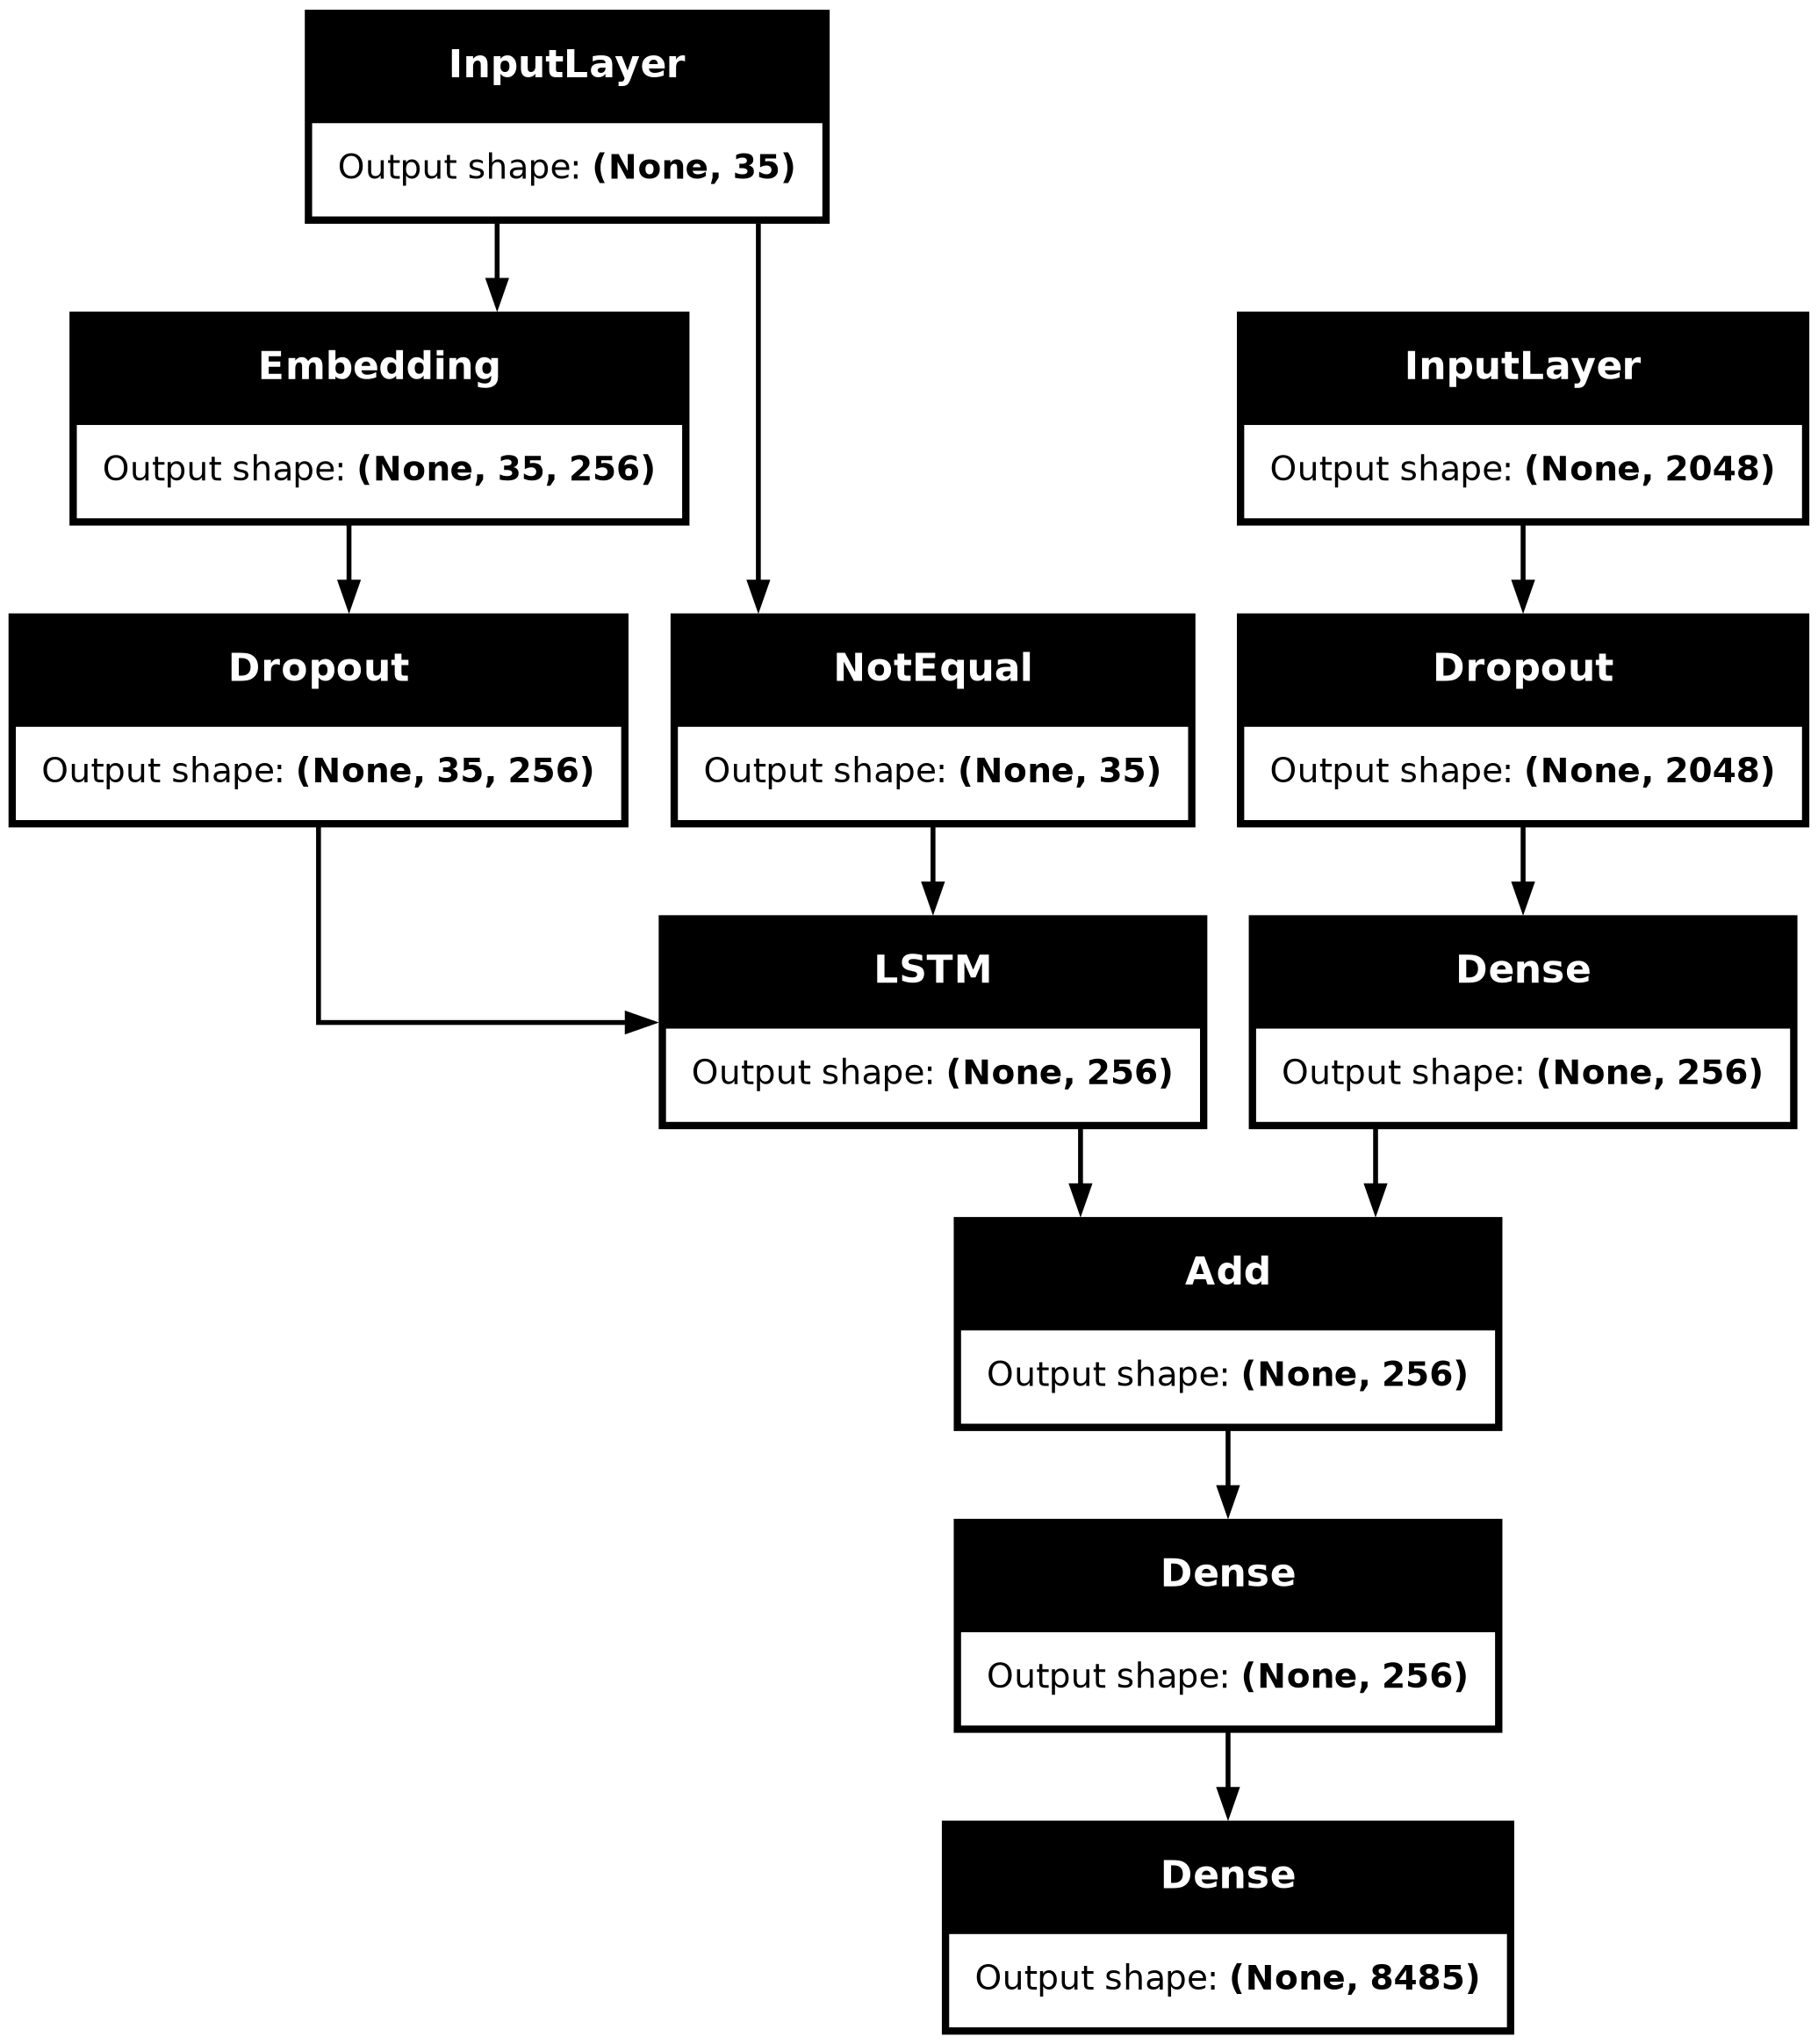

In [22]:
plot_model(text_gen_model, show_shapes = True)

## Train Model

In [24]:
epochs = 25
batch_size = 32
steps = len(train) // batch_size

# track the loss
history = { "loss" : []}

for i in range(epochs):
    
    # create the batch generator"
    generator = data_generator(train, mapped_captions, features, tokenizer, max_caption_length, vocab_size, batch_size)
    
    # fit data one epoch 
    print(f"Epoch {i + 1} / {epochs}:")
    hist = text_gen_model.fit(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)
    
    # append the loss into the history dictionary
    history['loss'].extend(hist.history['loss']) 

Epoch 1 / 25:
202/202 ━━━━━━━━━━━━━━━━━━━━ 54s 268ms/step - loss: 4.2552
Epoch 2 / 25:
202/202 ━━━━━━━━━━━━━━━━━━━━ 53s 265ms/step - loss: 3.7616
Epoch 3 / 25:
202/202 ━━━━━━━━━━━━━━━━━━━━ 53s 264ms/step - loss: 3.4957
Epoch 4 / 25:
202/202 ━━━━━━━━━━━━━━━━━━━━ 54s 266ms/step - loss: 3.3083
Epoch 5 / 25:
202/202 ━━━━━━━━━━━━━━━━━━━━ 54s 267ms/step - loss: 3.1623
Epoch 6 / 25:
202/202 ━━━━━━━━━━━━━━━━━━━━ 53s 263ms/step - loss: 3.0419
Epoch 7 / 25:
202/202 ━━━━━━━━━━━━━━━━━━━━ 53s 264ms/step - loss: 2.9391
Epoch 8 / 25:
202/202 ━━━━━━━━━━━━━━━━━━━━ 54s 266ms/step - loss: 2.8561
Epoch 9 / 25:
202/202 ━━━━━━━━━━━━━━━━━━━━ 55s 271ms/step - loss: 2.7784
Epoch 10 / 25:
202/202 ━━━━━━━━━━━━━━━━━━━━ 53s 262ms/step - loss: 2.7182
Epoch 11 / 25:
202/202 ━━━━━━━━━━━━━━━━━━━━ 53s 262ms/step - loss: 2.6610
Epoch 12 / 25:
202/202 ━━━━━━━━━━━━━━━━━━━━ 53s 262ms/step - loss: 2.6080
Epoch 13 / 25:
202/202 ━━━━━━━━━━━━━━━━━━━━ 53s 264ms/step - loss: 2.5516
Epoch 14 / 25:
202/202 ━━━━━━━━━━━━━━━━━━━━ 53s

### Plot the loss 

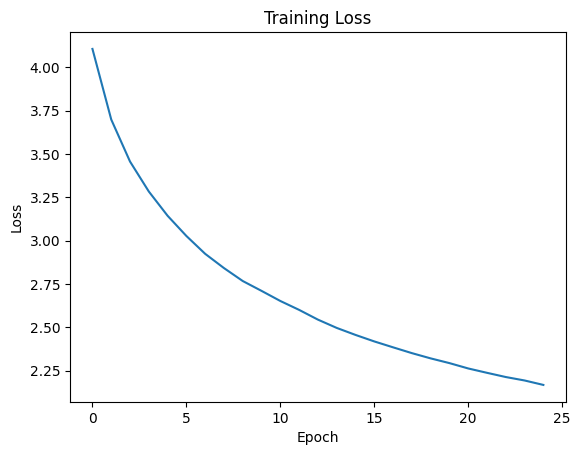

In [25]:
# Plot the training loss
import matplotlib.pyplot as plt
plt.plot(history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Save model

In [26]:
text_gen_model.save(os.path.join(WORKING_DIR, 'model_8k.h5'))

## Generate Captions for image

In [27]:
# Used to decode the Sequence
def index_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [29]:
# Generate the caption for given image
def predict_caption(text_gen_model, image_feature, tokenizer, max_length):
    
    # add start tag for generation process
    in_text = 'startseq'
    
    # iterate over the max length of sequence
    for i in range(max_length):
        
        # encode the input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        
        # pad the sequnce
        sequence = pad_sequences([sequence], max_length)
            
        # predict the next word
        yhat = text_gen_model.predict([image_feature,sequence], verbose = 0)
    
        # get the index with high probability
        yhat = np.argmax(yhat)
        
        # convert index to word
        word = index_to_word(yhat, tokenizer)
        
        # stop if word not found
        if word is None:
            break
        
        # append as predict word into the input to generate next word
        in_text += " " + word
        
        # stop iterating the loop as we each stop word
        if word == 'endseq':
            break
            
    # return the predicted caption for given image
    return in_text

In [30]:
from nltk.translate.bleu_score import corpus_bleu

# validate with test data
actual, predicted = list(), list()

for image in tqdm(test):
    # get the actual caption
    captions = mapped_captions[image]
    
    # predict the caption for the same image
    predicted_caption = predict_caption(text_gen_model, features[image], tokenizer, max_caption_length)
    
    # split into words
    actual_captions = [caption.split() for caption in captions]
    predicted_caption = predicted_caption.split()
    
    # append captions into their respective caption list
    actual.append(actual_captions)
    predicted.append(predicted_caption)
    

# Calculate BLEU score
print("BLEU-1: %f" %corpus_bleu(actual, predicted, weights = (1.0, 0, 0, 0)))
print("BLEU-2 %f" %corpus_bleu(actual, predicted, weights = (0.5, 0.5, 0, 0)))  
    
    

100%|██████████| 1619/1619 [19:27<00:00,  1.39it/s]


BLEU-1: 0.541972
BLEU-2 0.319138


## Visuals of Results

In [46]:
from PIL import Image
import matplotlib.pyplot as plt

# function to generate the caption
def Evaluate_caption(image_name, text_gen_model, features, tokenizer, max_caption_length):
    # Load the image
    image_id = image_name.split('.')[0]
    image_path = os.path.join(BASE_DIR, 'Images', image_name)

    image = Image.open(image_path)

    # Actual Caption of image
    print("-------------------------- Actual Captions ------------------------")
    print(*mapped_captions[image_id], sep= "\n")
    print()
    
    # Predicted Caption of image
    predicted_caption = predict_caption(text_gen_model, features[image_id], tokenizer, max_caption_length)
    print("------------------------- Predicted Caption ------------------------")
    print(predicted_caption)
    print()
    
    # Open image
    plt.imshow(image)

In [32]:
image_name = list(mapped_captions.keys())
image_ids = image_name[5000:5010]
print(image_ids)

['3310067561_b92017acab', '3310551665_15b79ef4ea', '33108590_d685bfe51c', '3312096605_f458757418', '3312779887_7682db7827', '3313232606_4ce7e16b87', '3313620862_0c65c645f5', '3314180199_2121e80368', '3314517351_69d70e62bd', '3314900697_c5c5ae9af6']


-------------------------- Actual Captions ------------------------
startseq climber in an orange helmet is ascending attached to rope whilst climbing rock face endseq
startseq gentleman is rock climbing endseq
startseq man rock-climbing endseq
startseq rock climber ascends endseq
startseq downward view of man with an orange helmet climbing rock endseq

------------------------- Predicted Caption ------------------------
startseq man in red shirt and jeans is sitting on rock with his arms crossed endseq



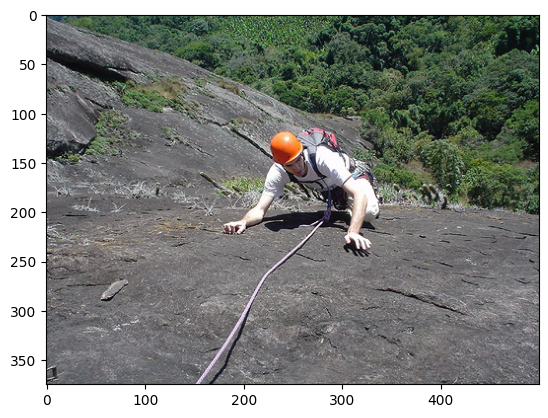

In [33]:
image = '140377584_12bdbdf2f8.jpg'
text_gen_model = text_gen_model    # text generator model
features = features
tokenizer = tokenizer
max_caption_length = max_caption_length

# load the model
Evaluate_caption(image, text_gen_model, features, tokenizer, max_caption_length)

-------------------------- Actual Captions ------------------------
startseq baby stands on the side of couch and knocks over lamp endseq
startseq small child climbs onto the arm of red couch endseq
startseq "baby indoors climbing on red couch arm reaching for lamp ." endseq
startseq small girl in teal dress on the arm of chair reaching for floor lamp endseq
startseq woman sitting on red couch inside the house endseq

------------------------- Predicted Caption ------------------------
startseq man sits in chair looking at somebody endseq



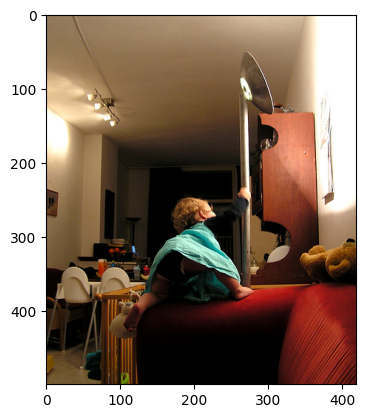

In [34]:
image = '1410193619_13fff6c875.jpg'
text_gen_model = text_gen_model    # text generator model
features = features
tokenizer = tokenizer
max_caption_length = max_caption_length

# load the model
Evaluate_caption(image, text_gen_model, features, tokenizer, max_caption_length)

-------------------------- Actual Captions ------------------------
startseq boy hits baseball with the bat endseq
startseq "a boy swings baseball bat and catcher stands behind him ." endseq
startseq kid hits baseball during game endseq
startseq little boy in teal uniform swinging baseball bat endseq
startseq the boy in the blue shirt is swinging baseball bat towards ball as the boy in the red helmet waits to catch him out endseq

------------------------- Predicted Caption ------------------------
startseq man in white shirt and blue shorts is hitting the ball with racket endseq



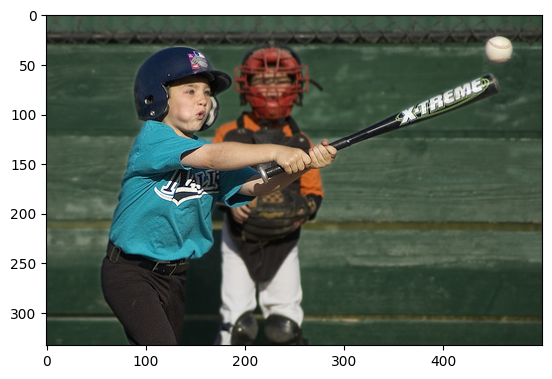

In [35]:
image = '141139674_246c0f90a1.jpg'
text_gen_model = text_gen_model    # text generator model
features = features
tokenizer = tokenizer
max_caption_length = max_caption_length

# load the model
Evaluate_caption(image, text_gen_model, features, tokenizer, max_caption_length)

-------------------------- Actual Captions ------------------------
startseq "one dog shaking the water off getting second dog wet" endseq
startseq two dogs are shaking off water while playing with ball on the edge of body of water endseq
startseq two dogs shake off water in an area with very little vegetation endseq
startseq two dogs shaking off water droplets on beach endseq
startseq two dogs shaking themselves dry on the sand endseq

------------------------- Predicted Caption ------------------------
startseq black dog is running through the grass endseq



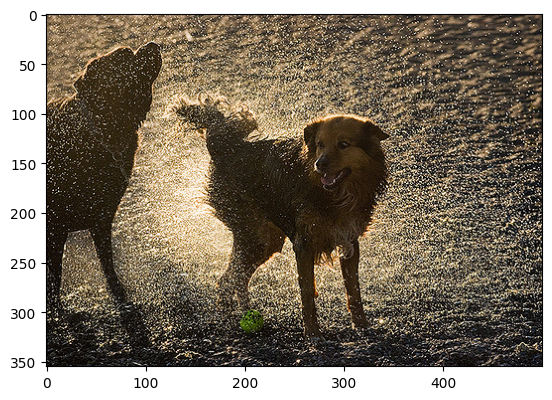

In [36]:
image = '1405221276_21634dcd58.jpg'
text_gen_model = text_gen_model    # text generator model
features = features
tokenizer = tokenizer
max_caption_length = max_caption_length

# load the model
Evaluate_caption(image, text_gen_model, features, tokenizer, max_caption_length)

-------------------------- Actual Captions ------------------------
startseq group of men in white shirts and dark shorts are running on an athletic field endseq
startseq group of people in matching uniforms jogging around track endseq
startseq group of soccer players run lap endseq
startseq team of men jog around orange cones endseq
startseq team of soccer players in white strips are running around cones on sports field endseq

------------------------- Predicted Caption ------------------------
startseq two men are playing soccer while third man looks on endseq



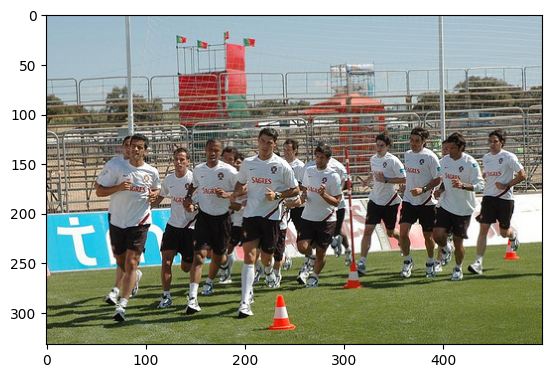

In [37]:
image = '3313232606_4ce7e16b87.jpg'
text_gen_model = text_gen_model    # text generator model
features = features
tokenizer = tokenizer
max_caption_length = max_caption_length

# load the model
Evaluate_caption(image, text_gen_model, features, tokenizer, max_caption_length)

## Test Model

In [38]:
# Function to generate caption and display image
def predict_on_real(image_path, feature_model, text_gen_model, tokenizer, max_length_caption):
    
    # Load the image
    image = load_img(image_path, target_size=(299, 299))  # InceptionV3 input shape
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Extract feature
    feature = feature_model.predict(image, verbose=0)

    # Predict the caption for extracted feature
    pred_caption = predict_caption(text_gen_model, feature, tokenizer, max_length_caption)

    # Show the image
    visual_image = Image.open(image_path)
    plt.imshow(visual_image)

    # Return the predicted caption
    return pred_caption

In [39]:
# Test the model real image
import requests

# generate the image caption from the given image url
def gen_cap_from_url(url: str, feature_model, text_gen_model, tokenizer, max_length_caption ) :

    # get the url
    image_url = url

    # fetch the image
    response = requests.get(url)

    # set the image file name
    temp_image = 'temp_image.jpg'

    # copy the content from given image url to image 
    with open (temp_image, 'wb') as f:
        f.write(response.content)
    
    # pass the image path to caption generator
    caption = predict_on_real(os.path.join(WORKING_DIR,temp_image), feature_model, text_gen_model, tokenizer, max_length_caption )

    # Display the predicted data
    print()
    print("------------------------ Predicted Caption --------------------------------")
    print(caption)

### Test on real image data

uploaded theimage url to get the caption of the given image


------------------------ Predicted Caption --------------------------------
startseq two young boys run on the field while the goalie is running towards the ball endseq


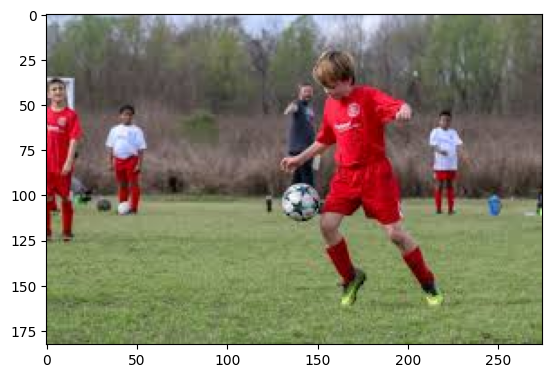

In [40]:
# call the gen_cap_from_url 
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR1mn1HfV0Z-I1iGiE5AE5Fiq0lpdSRsrxOSSPKEPtGag&s'
gen_cap_from_url(url, feature_model, text_gen_model, tokenizer, max_caption_length)


------------------------ Predicted Caption --------------------------------
startseq man in black shirt and black shorts is jumping into the air endseq


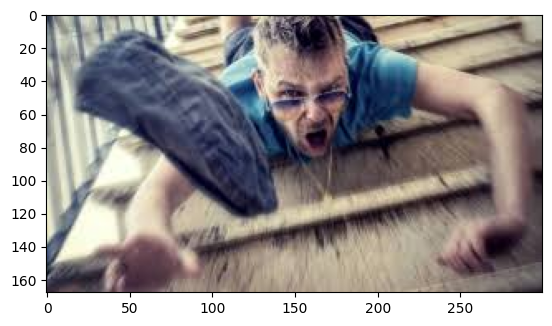

In [41]:
# call the gen_cap_from_url 
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRi69FtxYPqBRgOTbjlDAip4Nt-YI5rASeRiO-iyPerEQ&s'
gen_cap_from_url(url, feature_model, text_gen_model, tokenizer, max_caption_length)


------------------------ Predicted Caption --------------------------------
startseq man and woman sit on the floor of the counter endseq


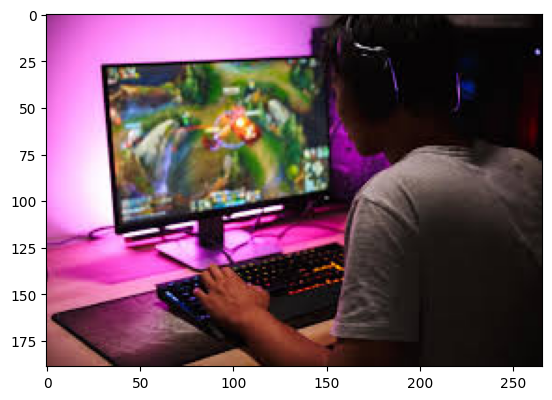

In [42]:
# call the gen_cap_from_url 
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQhIc1sC9kc41jnGPm7U_PHSqSErkRctLAeVB4aj-ig-Q&s'
gen_cap_from_url(url, feature_model, text_gen_model, tokenizer, max_caption_length)


------------------------ Predicted Caption --------------------------------
startseq man in black is climbing rock while another man watches from the background endseq


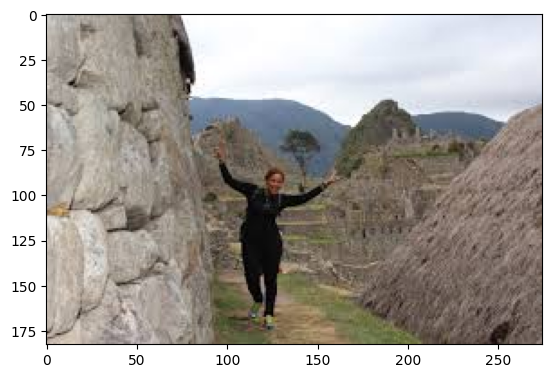

In [43]:
# call the gen_cap_from_url 
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR5PYN3BFSAigdwkiDr6iL2tmx7jPnzMPBMMDOHFGC-_g&s'
gen_cap_from_url(url, feature_model, text_gen_model, tokenizer, max_caption_length)

# Streamlit 

In [44]:
# install streamlit
!pip install streamlit -q

In [49]:
%%writefile app.py

# load the dependencies
import streamlit as st
from PIL import Image
import numpy as np
import requests
from io import BytesIO
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import pickle

# load the Featur extracting model --> used to extract the feature from given image
feature_model = InceptionV3()
feature_model = tf.keras.Model(inputs = feature_model.inputs, outputs = feature_model.layers[-2].output)

# Working directory
WORKING_DIR = '/kaggle/working/'

# Load the Features from pickle
def load_features():
    with open(os.path.join(WORKING_DIR,'features.pkl'),'rb') as f:
        features = pickle.load(f)
    return features


# Load tokenizer
def load_tokenizer():
    with open(os.path.join(WORKING_DIR, 'tokenizer.pkl'), 'rb', encoding = 'utf-8') as f:
        tokenizer_json = json.load(file.read())
        tokenizer = tokenizer_from_json(tokenizer_json)
    return tokenizer


# Load max lenght of caption
MAX_CAPTION_LENGTH = 35


# Load caption generator model
def load_caption_model():
    model = tf.keras.models.load_model(os.path.join(WORKING_DIR, 'model_8k.h5'))
    return model


# Preprocesse the input image for InceptionV3 model
def preprocess_image(image):
    image = image.resize((299, 299))
    image = img_to_array(image)
    image = np.expand_dims(image, axis = 0)
    image = preprocess_input(image)
    return image


# Used to decode the Sequence
def index_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


# Function to predict caption from image file
def predict_caption_from_file(image_file, feature_model, text_gen_model, tokenizer, max_caption_length):
    image = Image.open(image_file)
    image = image.resize((299, 299))
    image = np.array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Extract feature
    feature = feature_model.predict(image, verbose=0)

    # Predict the caption for extracted feature
    pred_caption = predict_caption(text_gen_model, feature, tokenizer, max_caption_length)

    return pred_caption


# Function to predict caption from image URL
def predict_caption_from_url(image_url, feature_model, text_gen_model, tokenizer, max_caption_length):
    # Fetch the image
    response = requests.get(image_url)

    # Read image data
    image = Image.open(io.BytesIO(response.content))
    image = image.resize((299, 299))
    image = np.array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Extract feature
    feature = feature_model.predict(image, verbose=0)

    # Predict the caption for extracted feature
    pred_caption = predict_caption(text_gen_model, feature, tokenizer, max_caption_length)

    return pred_caption

# load all the stuff
text_gen_model = load_caption_model()
tokenizer = load_tokenizer()
features = load_features()


# Streamlit UI
st.title("Image Captioning")

# Option to upload image file
st.markdown("### Upload Image File")
image_file = st.file_uploader("Choose an image file", type=["jpg", "jpeg", "png"])

# Option to enter image URL
st.markdown("### Or Enter Image URL")
image_url = st.text_input("Enter image URL")

# Display image
if image_file is not None:
    st.image(image_file, caption='Uploaded Image', use_column_width=True)
elif image_url != "":
    st.image(image_url, caption='Image from URL', use_column_width=True)

# Button to generate caption
if st.button("Generate Caption"):
    if image_file is not None:
        # Predict caption from uploaded image file
        caption = predict_caption_from_file(image_file, feature_model, text_gen_model, tokenizer, MAX_CAPTION_LENGTH)
        st.markdown(f"### Predicted Caption: {caption}")
    elif image_url != "":
        # Predict caption from image URL
        caption = predict_caption_from_url(image_url, feature_model, text_gen_model, tokenizer, MAX_CAPTION_LENGTH)
        st.markdown(f"### Predicted Caption: {caption}")
    else:
        st.error("Please upload an image file or enter an image URL.")


Overwriting app.py


## Run Model on Streamlit Locally using localtunnel technique


In [47]:
!npm install -g localtunnel

m#################.] | reify:yargs-parser: timing reifyNode:node_modules/localtK
changed 22 packages in 1s

3 packages are looking for funding
  run `npm fund` for details


In [50]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.19.2.2:8501
  External URL: http://34.123.118.106:8501

your url is: https://new-guests-dance.loca.lt
2024-04-30 16:56:28.444004: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 16:56:28.444059: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 16:56:28.445518: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-30 16:56:33.797 Uncaught app exception
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/streamlit/runtime/scriptrunner/script_runner.py"

In [ ]:
import streamlit as st
from PIL import Image
import requests
import numpy as np
import io

# Function to predict caption from image file
def predict_caption_from_file(image_file, feature_model, text_gen_model, tokenizer, max_caption_length):
    image = Image.open(image_file)
    image = image.resize((299, 299))
    image = np.array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Extract feature
    feature = feature_model.predict(image, verbose=0)

    # Predict the caption for extracted feature
    pred_caption = predict_caption(text_gen_model, feature, tokenizer, max_caption_length)

    return pred_caption

# Function to predict caption from image URL
def predict_caption_from_url(image_url, feature_model, text_gen_model, tokenizer, max_caption_length):
    # Fetch the image
    response = requests.get(image_url)

    # Read image data
    image = Image.open(io.BytesIO(response.content))
    image = image.resize((299, 299))
    image = np.array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Extract feature
    feature = feature_model.predict(image, verbose=0)

    # Predict the caption for extracted feature
    pred_caption = predict_caption(text_gen_model, feature, tokenizer, max_caption_length)

    return pred_caption

# Streamlit UI
st.title("Image Captioning")

# Option to upload image file
st.markdown("### Upload Image File")
image_file = st.file_uploader("Choose an image file", type=["jpg", "jpeg", "png"])

# Option to enter image URL
st.markdown("### Or Enter Image URL")
image_url = st.text_input("Enter image URL")

# Display image
if image_file is not None:
    st.image(image_file, caption='Uploaded Image', use_column_width=True)
elif image_url != "":
    st.image(image_url, caption='Image from URL', use_column_width=True)

# Button to generate caption
if st.button("Generate Caption"):
    if image_file is not None:
        # Predict caption from uploaded image file
        caption = predict_caption_from_file(image_file, feature_model, text_gen_model, tokenizer, max_caption_length)
        st.markdown(f"### Predicted Caption: {caption}")
    elif image_url != "":
        # Predict caption from image URL
        caption = predict_caption_from_url(image_url, feature_model, text_gen_model, tokenizer, max_caption_length)
        st.markdown(f"### Predicted Caption: {caption}")
    else:
        st.error("Please upload an image file or enter an image URL.")
